<a href="https://colab.research.google.com/github/KajalMishra-29/ML-LungCancerClassifier/blob/main/resnet_lung_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
import os
import cv2
import numpy as np
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

Image Preprocessing

In [3]:
directory = '/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset'
categories = ['Benign_cases', 'Malignant_cases', 'Normal_cases']

data = []
for i in categories:
  path = os.path.join(directory, i)
  class_num = categories.index(i)

  for file in os.listdir(path):
    file_path = os.path.join(path, file)
    img = cv2.imread(file_path)
    # preprocess steps
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    data.append([img, class_num]);

random.shuffle(data)

X, y = [], []
for feature, label in data:
  X.append(feature)
  y.append(label)

print('X length : ', len(X));
print('y counts : ', Counter(y))

X = np.array(X)
y = np.array(y)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10, stratify=y_temp)

X length :  1097
y counts :  Counter({1: 561, 2: 416, 0: 120})


Model with Transfer learning

In [5]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Custom fully connected layer
output = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = resnet_model.fit(X_train, y_train,
                           validation_data=(X_valid, y_valid),
                           epochs=30,
                           batch_size=32,
                           shuffle = True,
                           )

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5105 - loss: 1.0289 - val_accuracy: 0.5703 - val_loss: 0.9219
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.5700 - loss: 0.9403 - val_accuracy: 0.5729 - val_loss: 0.8982
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.5181 - loss: 0.8642 - val_accuracy: 0.6094 - val_loss: 0.8821
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.6024 - loss: 0.8597 - val_accuracy: 0.6224 - val_loss: 0.8708
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.6420 - loss: 0.8380 - val_accuracy: 0.6146 - val_loss: 0.8586
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.6484 - loss: 0.8353 - val_accuracy: 0.6224 - val_loss: 0.8484
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.6118 - loss: 0.8830 - val_accuracy: 0.6276 - val_loss: 0.8406
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - a

Unfreeze Some Layers for Fine-Tuning:

After the initial training, unfreeze some of the top layers in the base model to fine-tune them on your dataset. Lower the learning rate to avoid large updates that could erase pre-trained weights

In [6]:
# Unfreeze top layers of the base model
for layer in resnet_model.layers[-20:]:  # Adjust number of layers as needed
    layer.trainable = True

# Recompile the model with a lower learning rate
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Fine-tune the model
history_fine = resnet_model.fit(X_train ,y_train,
                                validation_data=(X_valid ,y_valid),
                                epochs=40,
                                batch_size=32,
                                shuffle = True,
                                )

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5767 - loss: 0.8670 - val_accuracy: 0.6562 - val_loss: 0.7509
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 0.7874 - loss: 0.5164 - val_accuracy: 0.6484 - val_loss: 0.7453
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.8893 - loss: 0.3538 - val_accuracy: 0.6406 - val_loss: 0.7435
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.9319 - loss: 0.2940 - val_accuracy: 0.6380 - val_loss: 0.7569
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.9370 - loss: 0.2499 - val_accuracy: 0.6406 - val_loss: 0.7586
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.9606 - loss: 0.1809 - val_accuracy: 0.6354 - val_loss: 0.7608
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.9684 - loss: 0.1711 - val_accuracy: 0.6380 - val_loss: 0.7625
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.9907 - loss: 0.1370 - val_accuracy: 0.6

# REPORT

In [7]:
y_pred = resnet_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step
Accuracy: 0.9545


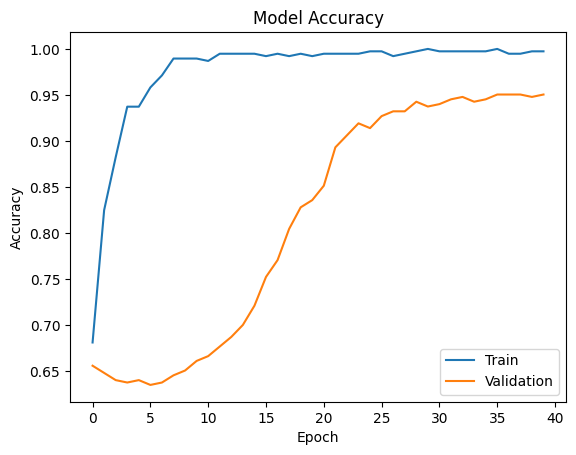

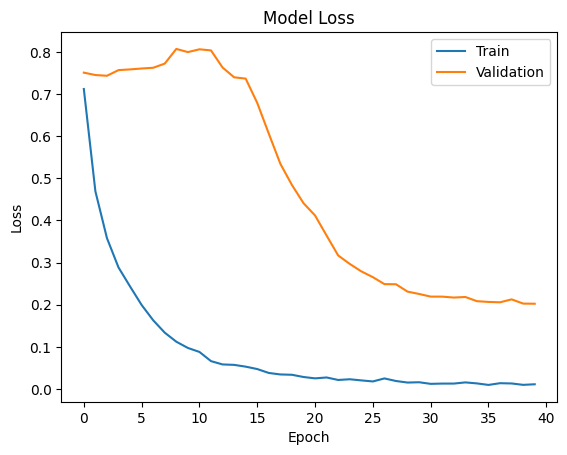

In [8]:
# Plot model accuracy
import matplotlib.pyplot as plt
plt.plot(history_fine.history['accuracy'], label='Train')
plt.plot(history_fine.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot model loss
plt.plot(history_fine.history['loss'], label='Train')
plt.plot(history_fine.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

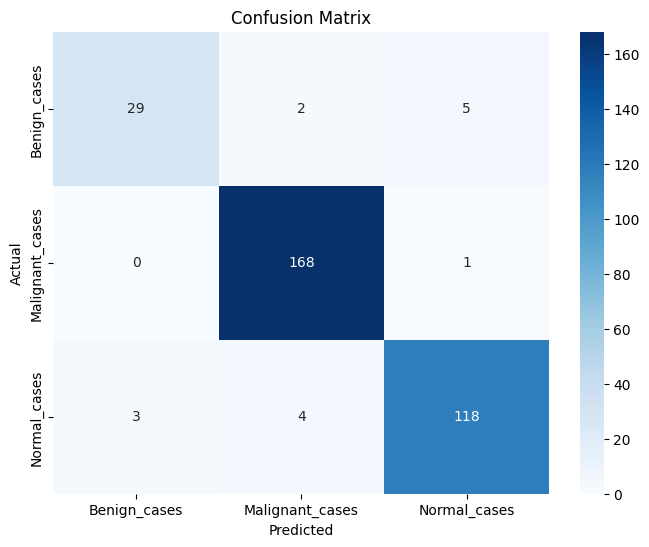

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step 


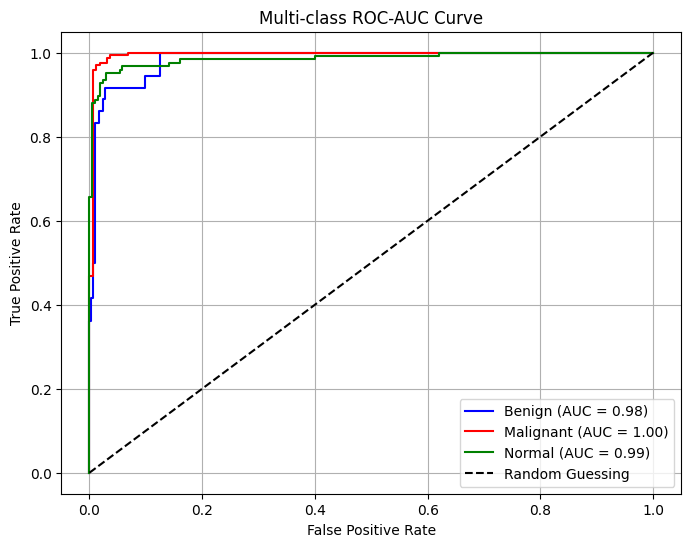

In [10]:
# Binarize the labels for ROC-AUC (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_prob = resnet_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
labels = ['Benign', 'Malignant', 'Normal']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC-AUC Curve')
plt.legend()
plt.grid()
plt.show()